# EAKF Solver Demo

This notebook demonstrates the new modular EAKF solver with Lorenz 63 and Lorenz 96 models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add scripts directory to path
sys.path.append(os.path.join(os.getcwd(), 'scripts'))
sys.path.append(os.path.join(os.getcwd(), 'scripts', 'models'))

from eakf_solver import EAKFSolver
from models.l63 import L63
from models.l96 import L96

## Lorenz 63 EAKF Example

In [2]:
# L63 parameters
l63_params = {"sigma":10.0, "rho": 28.0, "beta": 8.0/3.0}
initial_conditions = np.array([-5.08366039, -7.51663554,  4.76338787])
num_ensembles = 20

# EAKF setup
H = np.eye(3)  # Observe all variables
R = 0.1 * np.eye(3)  # Observation error covariance
dtda = 0.01  # Time step
oda = 1.0   # Time between observations

# Create EAKF solver
eakf_l63 = EAKFSolver(
    model_class=L63,
    model_params=l63_params,
    initial_conditions=initial_conditions,
    num_ensembles=num_ensembles,
    H=H, R=R, dtda=dtda, oda=oda,
    noise_strength=1.0,
    inflation=1.5,
    use_solver_ivp=False
)

print("L63 EAKF solver initialized!")
print(f"Initial ensemble shape: {eakf_l63.xa.shape}")
print(f"True initial state: {eakf_l63.true_state}")

L63 EAKF solver initialized!
Initial ensemble shape: (3, 20)
True initial state: [10.03518994 11.60545238 26.93939463]


In [3]:
# Run EAKF for L63
num_assimilations = 1000
solution_l63 = eakf_l63.run_eakf(num_assimilations, verbose=True)

print(f"Completed {num_assimilations} assimilation cycles")
print(f"True states shape: {solution_l63['true_states'].shape}")
print(f"Analysis states shape: {solution_l63['analysis_states'].shape}")

100%|██████████| 1000/1000 [00:08<00:00, 124.84it/s]


Completed 1000 assimilation cycles
True states shape: (1000, 3)
Analysis states shape: (1000, 3, 20)


In [6]:
solution_l63.keys()

dict_keys(['true_states', 'background_states', 'derivatives', 'analysis_states', 'previous_analysis', 'observations'])

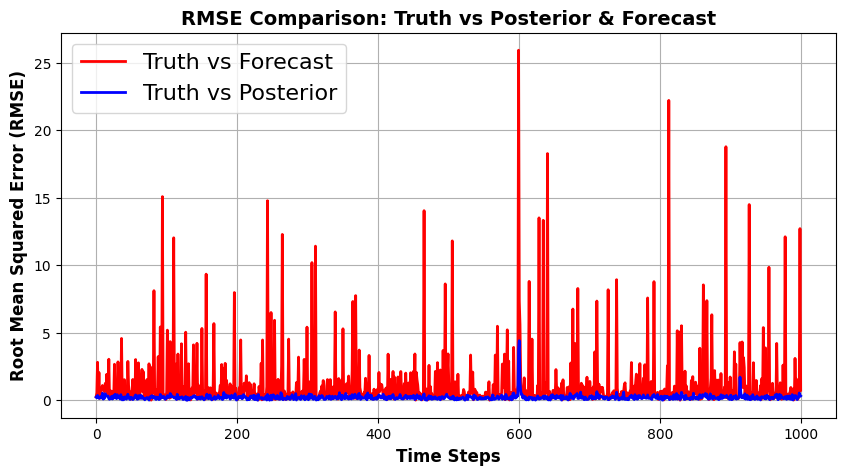

In [4]:
eakf_l63.visualize(show_plot=True)

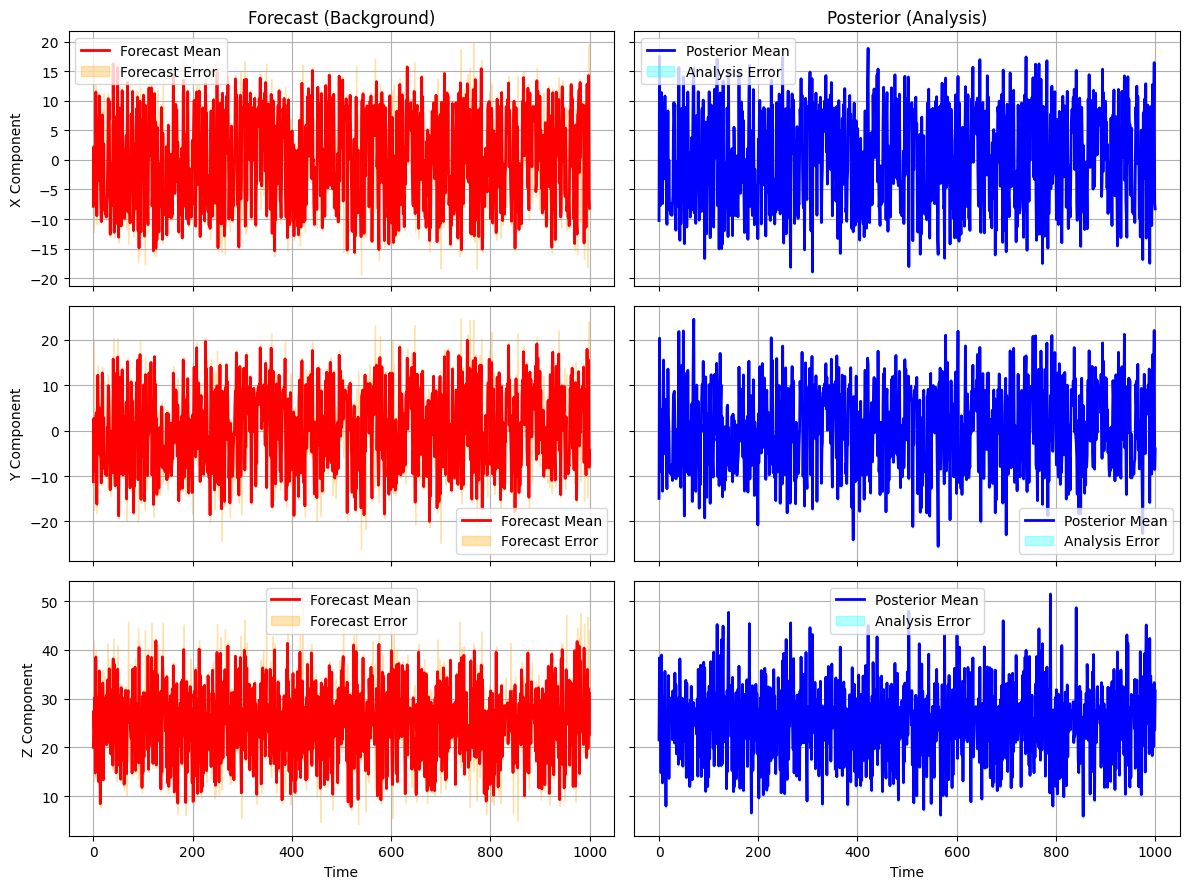

In [18]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, num_assimilations*oda, num_assimilations)
background = solution_l63['background_states'].mean(-1)
analysis = solution_l63['analysis_states'].mean(-1)
background_sd = solution_l63['background_states'].std(-1)
analysis_sd = solution_l63['analysis_states'].std(-1)

# Create the figure and subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=True, sharey='row')

# Component labels
components = ['X Component', 'Y Component', 'Z Component']

# Loop through components
for i in range(3):
    # Plot background (Forecast) in the left column
    axes[i, 0].plot(t, background[:, i], linewidth=2, color='red', label="Forecast Mean")
    axes[i, 0].fill_between(t, (background - background_sd)[:, i], (background + background_sd)[:, i],
                            color="orange", alpha=0.3, label="Forecast Error")
    axes[i, 0].set_ylabel(components[i])
    
    # Plot analysis (Posterior) in the right column
    axes[i, 1].plot(t, analysis[:, i], linewidth=2, color='blue', label="Posterior Mean")
    axes[i, 1].fill_between(t, (analysis - analysis_sd)[:, i], (analysis + analysis_sd)[:, i],
                            color="cyan", alpha=0.3, label="Analysis Error")
    axes[i, 0].legend()
    axes[i, 0].grid()
    axes[i, 1].legend()
    axes[i, 1].grid()

# Set titles for columns
axes[0, 0].set_title("Forecast (Background)")
axes[0, 1].set_title("Posterior (Analysis)")

# Common X-axis label
for ax in axes[-1, :]:
    ax.set_xlabel("Time")

# Add legends only in the first row


# Adjust layout
plt.tight_layout()
plt.show()

## Lorenz 96 EAKF Example

In [14]:
# L96 parameters
N = 20 
l96_params = {"N":N, "F":5.0}  # N, F
initial_conditions_l96 = L96.get_perturbed_initial(N, base_value=1.0, perturbation=0.1) * 5
num_ensembles_l96 = 10

# EAKF setup for L96
H_l96 = np.eye(N)
R_l96 = 0.1*np.eye(N)
dtda_l96 = 0.01
oda_l96 = 1.0

# Create EAKF solver for L96
eakf_l96 = EAKFSolver(
    model_class=L96,
    model_params=l96_params,
    initial_conditions=initial_conditions_l96,
    num_ensembles=num_ensembles_l96,
    H=H_l96, R=R_l96, dtda=dtda_l96, oda=oda_l96,
    noise_strength=1.0,
    inflation=3.0
)

print("L96 EAKF solver initialized!")
print(f"System size: {N}")
print(f"Observations: {H_l96.shape[0]} out of {N} variables")
print(f"Initial ensemble shape: {eakf_l96.xa.shape}")

L96 EAKF solver initialized!
System size: 20
Observations: 20 out of 20 variables
Initial ensemble shape: (20, 10)


In [15]:
# Run EAKF for L96
num_assimilations_l96 = 500
solution_l96 = eakf_l96.run_eakf(num_assimilations_l96, verbose=True)

print(f"Completed {num_assimilations_l96} assimilation cycles")
print(f"True states shape: {solution_l96['true_states'].shape}")
print(f"Analysis states shape: {solution_l96['analysis_states'].shape}")

100%|██████████| 500/500 [00:44<00:00, 11.20it/s]

Completed 500 assimilation cycles
True states shape: (500, 20)
Analysis states shape: (500, 20, 10)


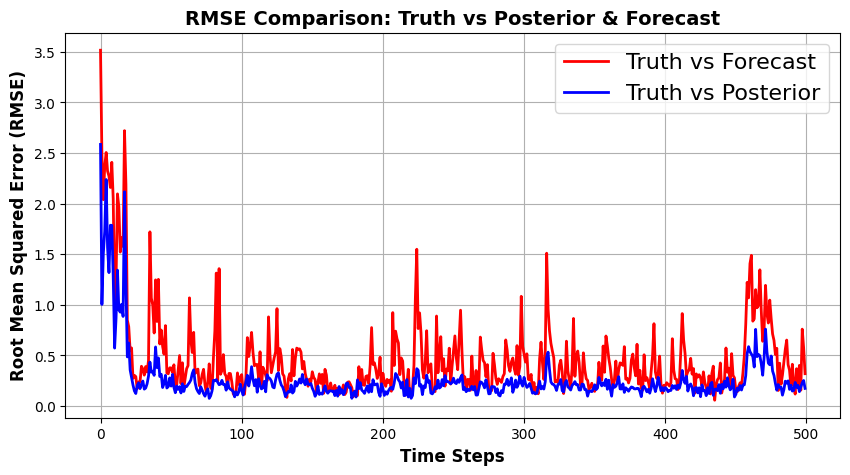

In [16]:
eakf_l96.visualize(show_plot=True)

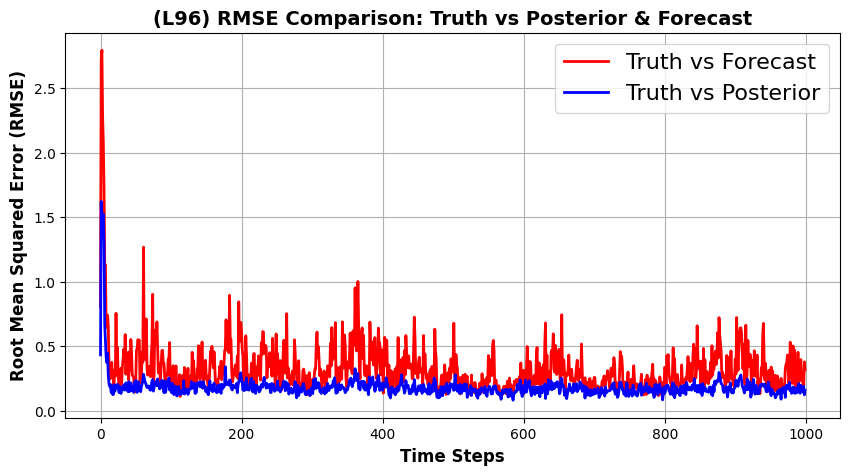

In [22]:
analysis = solution_l96['analysis_states'].mean(-1)
background = solution_l96['background_states'].mean(-1)
truth = solution_l96['true_states']
mae_background = np.sqrt(np.mean((truth - background)**2, axis=1))
mae_analysis = np.sqrt(np.mean((truth - analysis)**2, axis=1))

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(mae_background, label="Truth vs Forecast", linewidth=2, color='red')
plt.plot(mae_analysis, label="Truth vs Posterior", linewidth=2, color='blue')

plt.xlabel("Time Steps", fontsize=12, fontweight='bold')
plt.ylabel("Root Mean Squared Error (RMSE)", fontsize=12, fontweight='bold')
plt.title("(L96) RMSE Comparison: Truth vs Posterior & Forecast", fontsize=14, fontweight='bold')
plt.legend(prop={'size': 16})
plt.grid()
plt.show()

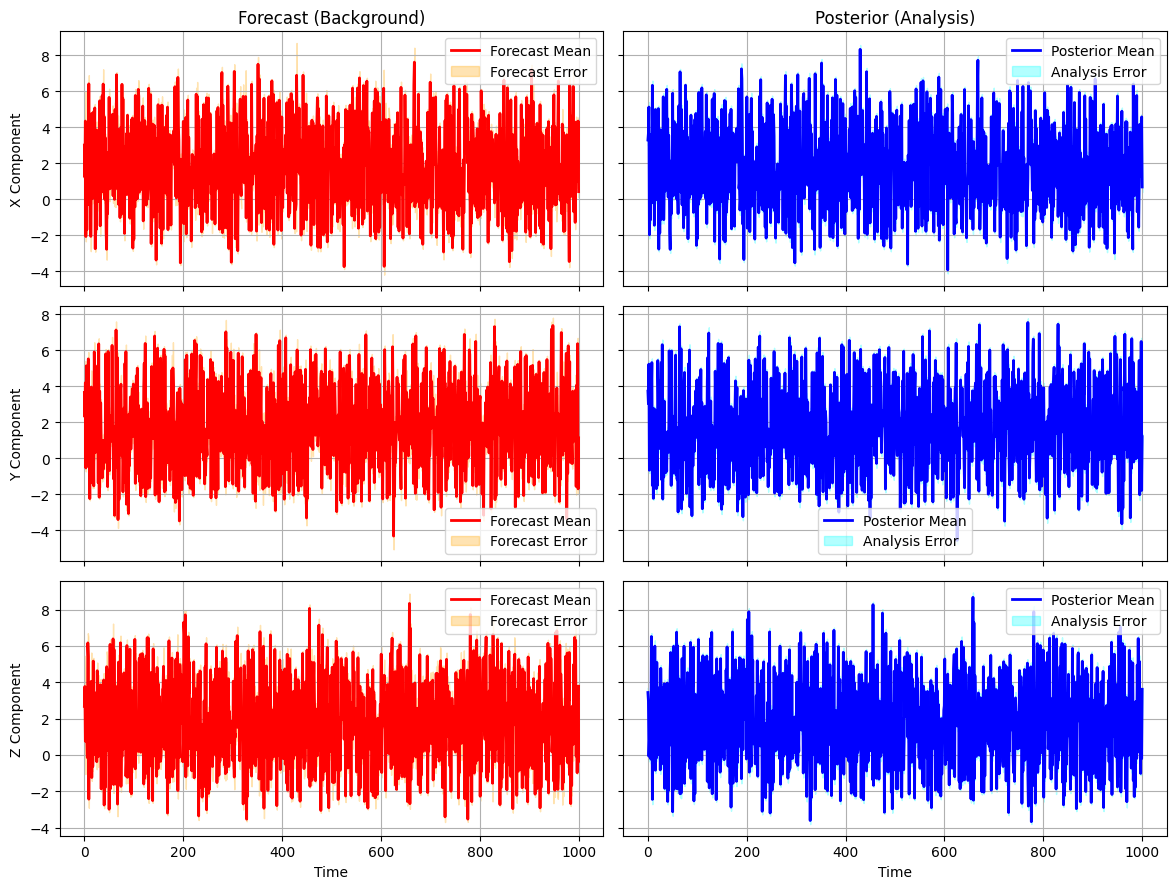

In [13]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, num_assimilations*oda, num_assimilations)
background = solution_l96['background_states'].mean(-1)
analysis = solution_l96['analysis_states'].mean(-1)
background_sd = solution_l96['background_states'].std(-1)
analysis_sd = solution_l96['analysis_states'].std(-1)

# Create the figure and subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=True, sharey='row')

# Component labels
components = ['X Component', 'Y Component', 'Z Component']

# Loop through components
for i in range(3):
    # Plot background (Forecast) in the left column
    axes[i, 0].plot(t, background[:, i], linewidth=2, color='red', label="Forecast Mean")
    axes[i, 0].fill_between(t, (background - background_sd)[:, i], (background + background_sd)[:, i],
                            color="orange", alpha=0.3, label="Forecast Error")
    axes[i, 0].set_ylabel(components[i])
    
    # Plot analysis (Posterior) in the right column
    axes[i, 1].plot(t, analysis[:, i], linewidth=2, color='blue', label="Posterior Mean")
    axes[i, 1].fill_between(t, (analysis - analysis_sd)[:, i], (analysis + analysis_sd)[:, i],
                            color="cyan", alpha=0.3, label="Analysis Error")
    axes[i, 0].legend()
    axes[i, 0].grid()
    axes[i, 1].legend()
    axes[i, 1].grid()

# Set titles for columns
axes[0, 0].set_title("Forecast (Background)")
axes[0, 1].set_title("Posterior (Analysis)")

# Common X-axis label
for ax in axes[-1, :]:
    ax.set_xlabel("Time")

# Add legends only in the first row


# Adjust layout
plt.tight_layout()
plt.show()

# PPO

In [1]:
from stable_baselines3 import PPO
model = PPO.load("./logs/L63_LSTM/weights/best_model/best_model.zip")

2025-07-28 15:09:04.543727: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 15:09:04.905303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753733344.987790 1647063 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753733345.013848 1647063 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753733345.192525 1647063 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

ModuleNotFoundError: No module named 'agents'